In [1]:
import logging
from Generator import Generator
from VertexProperty import VertexProperty
import sys
import graph_tool.all as gt
from Rule import Rule, RHS, LHS
from networkx.algorithms.graph_hashing import weisfeiler_lehman_graph_hash
from bson import json_util
from bson.objectid import ObjectId
import argparse
from os import path
import json
import uuid
import networkx as nx
import shutil
from Metrics import MapLinearity, MissionLinearity,Leniency, PathRedundancy
import matplotlib.pyplot as plt
from os.path import isfile, join, isdir
from os import listdir, mkdir, remove
import pickle
import pandas as pd

In [2]:
def makeGraph(mongoGraph):
    g = gt.Graph()
    IDtoIndex = {}
    vertices = []
    g.vertex_properties["vertex_property"] = g.new_vertex_property("python::object")
    for i, node in enumerate(mongoGraph["nodes"]):
        v = g.add_vertex()
        IDtoIndex[node["id"]] = i
        abbrev = node["abbrev"]
        label = node["label"]
        terminality = False
        mark = node["mark"]

        vertices.append(v)
        g.vp.vertex_property[v] = VertexProperty(label, abbrev, terminality, mark)

    for edge in mongoGraph["edges"]:
        u = vertices[IDtoIndex[edge["from"]]]
        v = vertices[IDtoIndex[edge["to"]]]
        g.add_edge(u, v)
    return g


def makeGrammar(grammar):
    axiom = makeGraph(grammar["axiom"])
    # gt.graph_draw(axiom, vertex_text=abbrevs, output="img/axiom.png")

    rules = []
    for i, rule in enumerate(grammar["rules"]):
        rule_name = rule["name"]
        rule_lhs = rule["lhs"]
        lhs_graph = makeGraph(rule_lhs)
        lhs = LHS(lhs_graph)
        # gt.graph_draw(lhs_graph, vertex_text=lhs_abbrevs, output="lhs"+ str(i) +".png")
        rule_rhss = rule["rhs"]
        rhss = []
        for j, rule_rhs in enumerate(rule_rhss):
            rhs_graph = makeGraph(rule_rhs["graph"])
            rhs = RHS(rhs_graph, rule_rhs["probability"])
            rhss.append(rhs)
            # gt.graph_draw(
            #     rhs_graph, vertex_text=rhs_abbrevs, output="rhs-"  + str(i)+ "-" + str(j) + ".png"
            # )
        rules.append(Rule(rule_name, lhs, rhss, 1))

    return (axiom, rules)
safe_rooms = {"e", "g", "l", "lf", "lm", "n", "k", "kf", "km"}
non_critical_rooms = ["n", "l", "t"]

In [3]:
def hasMoreThanFour(graph):
    for v in graph.vertices():
        if len(graph.get_all_neighbors(v)) > 4:
            return True
    return False

In [4]:
def containsKM(graph):
    for v in graph.vertices():
        if graph.vp.vertex_property[v].abbrev == "km":
            return True
    return False

In [5]:
def findExit(graph):
    exit = 0
    for v in graph.vertices():
        if(graph.vp.vertex_property[v].abbrev == "g"):
            exit = v
            break
    return exit

In [6]:
def genExamples(gen, config):
    leniency = []
    map_linearity = []
    mission_linearity = []
    path_redundancy = []
    has_more_than_4 = []
    has_km= []
    sample_ids = []
    training_samples = []
    for i in range(10000):
        sample, sample_id = gen.applyRules(config)
        exit = findExit(sample)
        sample_ids.append(sample_id)
        has_more_than_4.append(hasMoreThanFour(sample))
        has_km.append(containsKM(sample))
        leni =  Leniency(sample,safe_rooms)
        mission_lin =  MissionLinearity(sample,0,exit)
        path_red =  PathRedundancy(sample,non_critical_rooms)
        map_lin = MapLinearity(sample) 
        leniency.append(leni)
        mission_linearity.append(mission_lin)
        map_linearity.append(map_lin)
        path_redundancy.append(path_red)
    data = {"Sample ID": sample_ids, "Leniency": leniency, "Mission Linearity": mission_linearity, "Map Linearity": map_linearity, "Path Redundancy": path_redundancy , "More Than Four": has_more_than_4, "Has KM": has_km}
    df = pd.DataFrame(data)
    return df

In [7]:
def cleanDir(dir_path):
    if isdir(dir_path):
        shutil.rmtree(dir_path)

In [8]:
def SaveTrainingSet(samples, grammar):
    dir_path = "../data/trees/training-set-dormans/"
    if isdir(dir_path):
        shutil.rmtree(dir_path)
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        # this is really dumb we are reading a file just to dump it again
        filename = "../data/generation-trees/" + grammar + "/" + sample_id + ".pkl"
        input_file = open(filename, "rb")
        tree = pickle.load(input_file)
        tree.saveTree(dir_path + sample_id + ".pkl")

In [9]:
def SaveGraphs(samples, grammar):
    dir_path = "../data/sample-graphs/to-score/"
    if not isdir(dir_path):
        mkdir(dir_path)
    for sample_id in samples:
        # this is really dumb we are reading a file just to dump it again
#         filename = "../data/sample-graphs/" + grammar + "/" + sample_id + ".gt"
        filename = "../data/sample-graphs/" + grammar + "/" + sample_id 
        g = gt.load_graph(filename)
#         g.save(dir_path + sample_id + '.gt')
        g.save(dir_path + sample_id)

In [21]:
def drawExpRange(df, xlabel, ylabel, thresx,thresy,ax, axis = [False, False]):
    x = df[xlabel]
    y = df[ylabel]
    ax.hist2d(x,y, bins=[25,25], range=[[0,1],[0,1]])
    ax.ylim([0,1])
    if axis[0]:
        ax.axvline(x=thresx, color='r')
    if axis[1]:
        ax.plot([thresy, thresy, thresy], color='r')
    ax.xlim([0,1])
    ax.xlabel(xlabel)
    ax.ylabel(ylabel)
    ax.colorbar()
    return ax

In [11]:
with open("../data/grammars/dormans-grammar.json") as json_file:
    data = json.load(json_file)

axiom, rules = makeGrammar(data)
config = {"max_applications": 30, "sampling_method": "uniform"}
gen = Generator(axiom, rules, "dormans-grammar")

In [12]:
thres1 = 0.6
thres2 = 0.6
cleanDir("../data/sample-graphs/dormans-grammar")
df= genExamples(gen,config)
# print(len(training_samples))

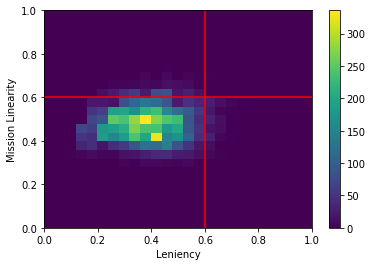

In [22]:
fig = drawExpRange(df, 'Leniency', 'Mission Linearity',thres1, thres2, plt,[True, True])

In [14]:
df["Path Redundancy"]

0       0.033333
1       0.034483
2       0.120000
3       0.038462
4       0.100000
          ...   
9995    0.046512
9996    0.142857
9997    0.166667
9998    0.090909
9999    0.062500
Name: Path Redundancy, Length: 10000, dtype: float64

In [15]:
# SaveTrainingSet(training_samples, "dormans-grammar")

In [16]:
# config = {"max_applications": 30, "sampling_method": "grammar"}
# gen_altered = Generator(axiom, rules, "dormans-grammar-altered")
# sample, sample_id = gen.applyRules(config)
# gen_altered.learnParameters("../data/trees/training-set-dormans/")

In [17]:
# cleanDir("../data/sample-graphs/dormans-grammar-altered")
# trained_df,_ = genExamples(gen_altered,config,thres1, thres2)

In [18]:
# fig = drawExpRange(trained_df, 'Leniency', 'Mission Linearity',thres1, thres2, [True, True])

In [19]:
df.to_csv("original-grammar-2.csv")